In [1]:
import os
import tqdm
import random
import pickle
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import shap
import xgboost as xgb
from scipy import stats
from zeo_amd.classify import train_classifier, get_datasets, get_metrics, get_best_classifier
from zeo_amd.plotting import savefig

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)

xgb_file = "../data/xgb_ensembles_hyp.pkl"
hyp = pd.read_csv("../data/hyp_dm.csv", index_col=0)

cols = sorted(list(set(hyp.columns) & set(dm.columns)))

dm = dm.loc[cols, cols]
hyp = hyp[cols]

synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]
hfeat = pd.read_csv("../data/hyp_features.csv", index_col=0).set_index("id")

In [3]:
X = dm.values
X_norm = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)

## Training classifiers

In [12]:
MIN_SYNTHESIS = 0.25
NUM_ROUNDS = 100
INORGANICS = ['Al', 'B', "Be", 'Ca', 'Co', 'F', 'Ga', 'Ge', 'K', 'Mg', 'Na', 'P', 'Si', 'Zn']

In [13]:
if not os.path.exists(xgb_file):
    ensemble = {}

    for _label in INORGANICS:
        y = (synth[_label] > MIN_SYNTHESIS).values

        for n in range(NUM_ROUNDS):
            clf = get_best_classifier()

            X_train, X_test, y_train, y_test = get_datasets(
                X, y, test_size=0.1, balanced=True, random_seed=143,
            )

            clf.fit(X_train, y_train)

            ensemble[_label] = ensemble.get(_label, []) + [clf]

        with open(xgb_file, "wb") as f:
            pickle.dump(ensemble, f)

## Obtaining the predictions of inorganic labels for all hypothetical zeolites

In [16]:
with open(xgb_file, "rb") as f:
    ensemble = pickle.load(f)

In [17]:
predictions = {}

for label, clf_list in tqdm.tqdm(ensemble.items()):
    values = [
        clf.predict(hyp.values)
        for clf in clf_list
    ]
    predictions[label] = values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [02:34<00:00, 11.06s/it]


In [68]:
mean_predictions = pd.DataFrame({
    label: np.stack(preds).mean(0)
    for label, preds in predictions.items()
}, index=hyp.index)

std_predictions = pd.DataFrame({
    label: np.stack(preds).std(0)
    for label, preds in predictions.items()
}, index=hyp.index)

In [113]:
mean_predictions.to_csv("../data/hyp_predictions.csv")

In [38]:
final = pd.concat([mean_predictions, hfeat], axis=1)

## Filtering structures based on energy

In [110]:
ex_Be = 261338

_df = final.loc[
    (final["Be"] == 1)
    & (final['density'] < 18)
].sort_values("relative_energy", ascending=False)

In [34]:
ex_Ge = 210242
ex_Na = 266841
ex_K = 323245

In [60]:
ex_max = 269415

In [86]:
final.loc[306823]

Al                       1.0
B                       0.07
Be                      0.97
Ca                      0.18
Co                      0.65
F                       0.35
Ga                      0.51
Ge                      0.58
K                       0.11
Mg                      0.62
Na                      0.21
P                        1.0
Si                      0.04
Zn                      0.48
formula              O96Si48
relative_energy    16.474716
density            14.070536
Name: 306823, dtype: object

## Example: comparing against LTA

In [115]:
bad_LTA = 313030
good_LTA = 308105

In [116]:
_df = pd.concat([hyp, final], axis=1)
_df = _df.sort_values("LTA").iloc[:1000]

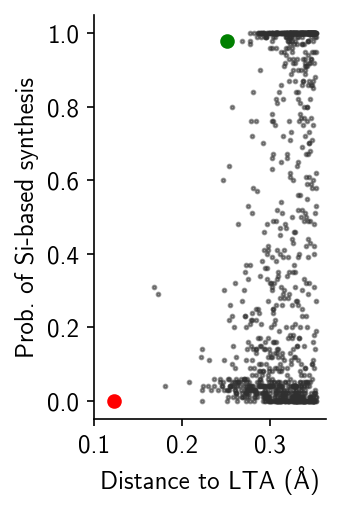

In [132]:
fig, ax = plt.subplots(figsize=(2, 3.5))

ax.scatter(
    _df["LTA"],
    _df["Si"],
    s=3,
    c="#303030",
    alpha=0.5,
)
ax.scatter(
    _df.loc[good_LTA, "LTA"],
    _df.loc[good_LTA, "Si"],
    c='g',
)
ax.scatter(
    _df.loc[bad_LTA, "LTA"],
    _df.loc[bad_LTA, "Si"],
    c='r',
)

ax.set_xlabel("Distance to LTA (Å)", fontsize=12)
ax.set_ylabel("Prob. of Si-based synthesis", fontsize=12)

ax.set_xlim(0.1)

savefig(fig, "06-hyp-lta.pdf")
plt.show()

In [136]:
synth.loc["LTA"]

Al                 0.685714
As                 0.000000
B                  0.000000
Be                 0.000000
Ca                 0.000000
Ce                 0.000000
Cl                 0.014286
Co                 0.021429
Cr                 0.000000
Cs                 0.000000
Cu                 0.000000
F                  0.628571
Fe                 0.007143
Ga                 0.057143
Ge                 0.135714
H2SO4              0.000000
HNO3               0.000000
K                  0.007143
Li                 0.007143
Mg                 0.007143
Mn                 0.035714
Na                 0.142857
Ni                 0.007143
P                  0.442857
Rb                 0.000000
S                  0.000000
SO4                0.000000
Si                 0.571429
Sn                 0.000000
Sr                 0.000000
Te                 0.000000
Ti                 0.007143
V                  0.000000
Zn                 0.014286
ethanol            0.000000
ethylene glycol    0